In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn
import warnings
warnings.filterwarnings("ignore")

# yahoo finance is used to fetch data
import yfinance as yf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Creating  a linear regression model
from sklearn.linear_model import LinearRegression

from pmdarima import auto_arima

In [2]:
aapl = yf.download('AAPL','2015-01-01','2021-06-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
nke = yf.download('NKE','2015-01-01','2021-06-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
googl = yf.download('GOOGL','2015-01-01','2021-06-01')

[*********************100%***********************]  1 of 1 completed


In [5]:
amzn = yf.download('AMZN','2015-01-01','2021-06-01')

[*********************100%***********************]  1 of 1 completed


In [6]:
df= pd.DataFrame()

In [7]:
df['AAPL']=aapl['Adj Close']
df['NKE']=nke['Adj Close']
df['GOOGL']=googl['Adj Close']
df['AMZN']=amzn['Adj Close']


In [8]:
df.head()

,AAPL,NKE,GOOGL,AMZN
Date,,,,
2014-12-31,25.020121,44.705849,530.659973,310.350006
2015-01-02,24.782108,44.185093,529.549988,308.519989
2015-01-05,24.083958,43.473709,519.460022,302.190002
2015-01-06,24.086229,43.217972,506.640015,295.290009
2015-01-07,24.423977,44.110699,505.149994,298.420013


In [9]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,AAPL,NKE,GOOGL,AMZN
AAPL,0.000349,0.000146,0.000193,0.000202
NKE,0.000146,0.000294,0.000136,0.000118
GOOGL,0.000193,0.000136,0.000286,0.000211
AMZN,0.000202,0.000118,0.000211,0.000367


In [12]:
#cov_matrix display us the directional relationship between the returns on two assets
#covariance of Apple an Apple is variance of that assets

In [11]:
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,AAPL,NKE,GOOGL,AMZN
AAPL,1.000000,0.455196,0.610059,0.564730
NKE,0.455196,1.000000,0.470447,0.359123
GOOGL,0.610059,0.470447,1.000000,0.652173
AMZN,0.564730,0.359123,0.652173,1.000000


In [13]:
#corr_matrix display to us the degree to which two securities move in relation to each other
#As you can see, an asset always has a perfectly positive correlation of 1 with itself.

In [14]:
w = {'AAPL': 0.1, 'NKE': 0.2, 'GOOGL': 0.5, 'AMZN': 0.2}
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

0.00021354316732235856

In [ ]:
#Thus we have found the portfolio variance. 
#But for truly optimizing the portfolio, 
#we cant plug in random weights.
#We will need to calculate it according to what gives us maximum expected returns.

In [ ]:
#The mean of returns (given by change in prices of asset stock prices) give us the expected returns of that asset.
#The sum of all individual expected returns further multiplied by the weight of 
#assets give us expected return for the portfolio.

In [15]:
# Yearly returns for individual companies
ind_er = df.resample('Y').last().pct_change().mean()
ind_er

AAPL     0.311452
NKE      0.191672
GOOGL    0.248715
AMZN     0.444801
dtype: float64

In [16]:
# Portfolio returns
w = [0.1, 0.2, 0.5, 0.2]
port_er = (w*ind_er).sum()
port_er

0.28279702128234946

In [17]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

AAPL     0.295282
NKE      0.270957
GOOGL    0.267433
AMZN     0.302773
dtype: float64

In [18]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AAPL,0.311452,0.295282
NKE,0.191672,0.270957
GOOGL,0.248715,0.267433
AMZN,0.444801,0.302773


In [ ]:
#Amazon has the maximum risk attached but it also offers the maximum returns.
#Apple lies somewhere in the middle, with average risk and return rates.

In [19]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000


In [20]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [21]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [22]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,AAPL weight,NKE weight,GOOGL weight,AMZN weight
0,0.305473,0.226981,0.237641,0.322132,0.133094,0.307133
1,0.283506,0.228023,0.302347,0.234365,0.314416,0.148872
2,0.311093,0.227655,0.166382,0.321948,0.153131,0.358540
3,0.348877,0.244341,0.194273,0.096084,0.233043,0.476600
4,0.336735,0.243137,0.287281,0.060659,0.277444,0.374617


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

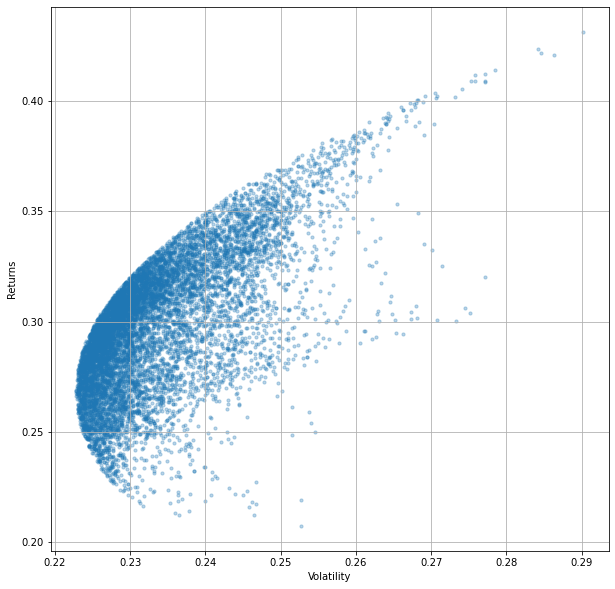

In [23]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])


In [24]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns         0.266248
Volatility      0.222786
AAPL weight     0.151790
NKE weight      0.403889
GOOGL weight    0.285973
AMZN weight     0.158348
Name: 1297, dtype: float64

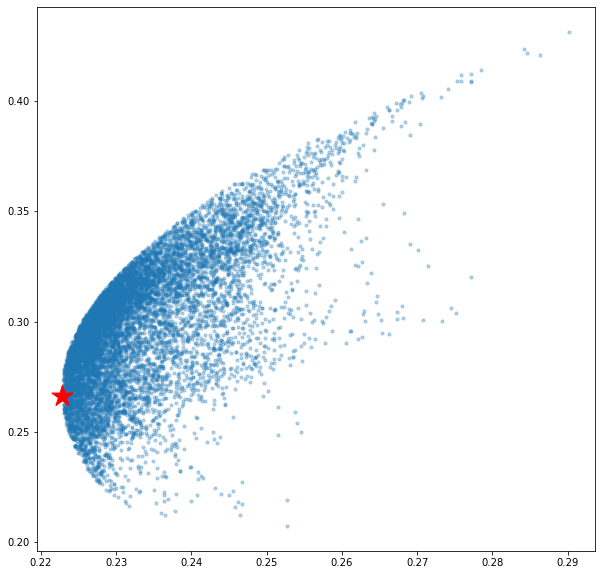

In [25]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

In [26]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns         0.402534
Volatility      0.269153
AAPL weight     0.236103
NKE weight      0.041764
GOOGL weight    0.001077
AMZN weight     0.721056
Name: 1384, dtype: float64

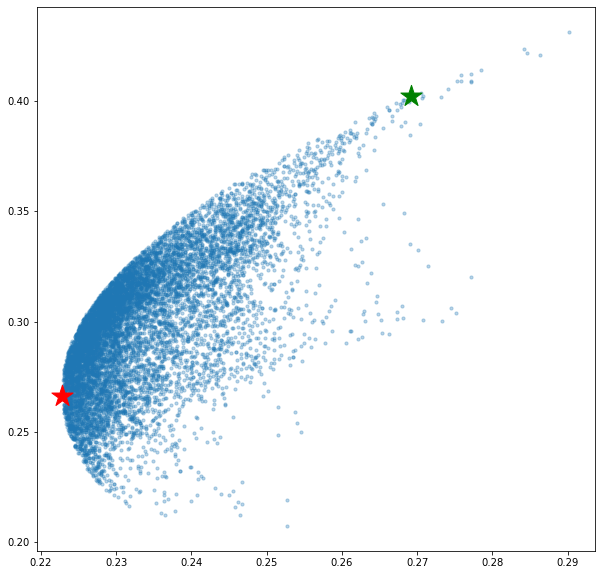

In [27]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)